## Run MD with vanilla/og system and then check that difference in energies between vanilla vs hybrid system are close to 0

In [1]:
from tqdm import tqdm_notebook
import openmmtools
import matplotlib.pyplot as plt
import pickle

from simtk import openmm
from simtk.openmm import unit
import openmmtools
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from openmmtools import cache
from openmmtools.constants import kB

from perses.annihilation.lambda_protocol import RESTState, RESTCapableRelativeAlchemicalState, RESTCapableLambdaProtocol
from perses.dispersed import feptasks

import numpy as np

from perses.app.relative_point_mutation_setup import PointMutationExecutor


INFO:rdkit:Enabling RDKit 2021.03.4 jupyter extensions


## Generate htf

In [2]:
from perses.app.relative_point_mutation_setup import PointMutationExecutor
from openeye import oechem

In [3]:
rbd_file = "/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/input/rbd_protonated.pdb"
ace2_file = "/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/input/ace2_protonated.pdb"


In [4]:
import simtk.openmm as openmm
import simtk.openmm.app as app
import simtk.unit as unit
import numpy as np

# Set up logger
import logging
_logger = logging.getLogger("setup")
_logger.setLevel(logging.INFO)

class PointMutationExecutor2(PointMutationExecutor):

    def _solvate(self,
               topology,
               positions,
               water_model,
               phase,
               ionic_strength,
               box_dimensions=None):
        """
        Generate a solvated topology, positions, and system for a given input topology and positions.
        For generating the system, the forcefield files provided in the constructor will be used.
        Parameters
        ----------
        topology : app.Topology
            Topology of the system to solvate
        positions : [n, 3] ndarray of Quantity nm
            the positions of the unsolvated system
        forcefield : SystemGenerator.forcefield
            forcefield file of solvent to add
        water_model : str
            solvent model to use for solvation
        phase : str
            if phase == vacuum, then the complex will not be solvated with water; else, it will be solvated with tip3p
        ionic_strength : float * unit.molar
            the total concentration of ions (both positive and negative) to add using Modeller.
            This does not include ions that are added to neutralize the system.
            Note that only monovalent ions are currently supported.
        Returns
        -------
        solvated_topology : app.Topology
            Topology of the system with added waters
        solvated_positions : [n + 3(n_waters), 3] ndarray of Quantity nm
            Solvated positions
        solvated_system : openmm.System
            The parameterized system, containing a barostat if one was specified.
        """
        modeller = app.Modeller(topology, positions)
    
        geompadding = 0.9 * unit.nanometers
        maxSize = max(max((pos[i] for pos in positions))-min((pos[i] for pos in positions)) for i in range(3))
        vectors = openmm.Vec3(1,0,0), openmm.Vec3(1/3,2*np.sqrt(2)/3,0), openmm.Vec3(-1/3,np.sqrt(2)/3,np.sqrt(6)/3)
        boxVectors = [(maxSize+geompadding)*v for v in vectors]
        
        # Now we have to add missing atoms
        if phase != 'vacuum':
            _logger.info(f"solvating at {ionic_strength} using {water_model}")
            modeller.addSolvent(self.system_generator.forcefield, model=water_model, boxVectors=boxVectors, ionicStrength=ionic_strength)
        else:
            pass

        solvated_topology = modeller.getTopology()
        solvated_positions = modeller.getPositions()

        # Canonicalize the solvated positions: turn tuples into np.array
        solvated_positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in solvated_positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
        solvated_system = self.system_generator.create_system(solvated_topology)

        return solvated_topology, solvated_positions, solvated_system


In [5]:
solvent_delivery = PointMutationExecutor2(rbd_file,
                        '1',
                        '501',
                        'TYR',
                        ligand_input=ace2_file,
                        forcefield_files=['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml', '/home/zhangi/choderalab/og_openmmforcefields/openmmforcefields/amber/ffxml/GLYCAM_06j-1.xml'],
                        ionic_strength=0.15*unit.molar,
                        rest_radius=0.2,
                        generate_unmodified_hybrid_topology_factory=False,
                        generate_rest_capable_hybrid_topology_factory=True,
                        conduct_endstate_validation=False,
                       )

DEBUG:openmmforcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:setup:solvating at 0.15 M using tip3p
INFO:setup:solvating at 0.15 M using tip3p
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:local_atom_map: {2605: 2605, 2606: 2606, 2607: 2607, 2608: 2608, 2609: 2609, 2610: 2610, 2611: 2611}
INFO:proposal_generator:the mapped atom names are: [('N', 'N'), ('H', 'H'), ('CA', 'CA'), ('HA', 'HA'), ('C', 'C'), ('O', 'O'), ('CB', 'CB')]
INFO:setup:Changed particle 19's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 19's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 191's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 191's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 256's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 256's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 293's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INF

INFO:setup:Changed particle 947's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 947's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 998's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 998's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1031's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1031's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1282's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1282's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1373's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1373's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1408's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1408's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 1521's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 1521's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 163

INFO:geometry:log probability choice of torsions and atom order: -21.879230568629588
INFO:geometry:creating platform, integrators, and contexts; setting growth parameter


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 14 new atoms
INFO:geometry:	reduced angle potential = 1.7617204787417506.
INFO:geometry:	reduced angle potential = 0.16986825567205344.
INFO:geometry:	reduced angle potential = 0.03340309223359637.
INFO:geometry:	reduced angle potential = 0.06077720120197149.
INFO:geometry:	reduced angle potential = 0.033397108961929614.
INFO:geometry:	reduced angle potential = 3.46666258035115.
INFO:geometry:	reduced angle potential = 0.009116467172486143.
INFO:geometry:	reduced angle potential = 0.0004357212530489901.
INFO:geometry:	reduced angle potential = 1.060686778329862.
INFO:geometry:	reduced angle potential = 0.0005700652260334259.
INFO:geometry:	reduced angle potential = 0.8112533798572975.
INFO:geometry:	reduced angle potential = 0.3714271922874583.
INFO:geometry:	reduced angle potential = 0.49511624788782677.
INFO:geometry:	reduced angle potential = 0.6073773176656405.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-no

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 4814.12706797297


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -26.721934418117012
INFO:geometry:final reduced energy 4902.850518225182
INFO:geometry:sum of energies: 4787.405133554853
INFO:geometry:magnitude of difference in the energies: 115.4453846703294
INFO:geometry:Final logp_proposal: 112.71637129379991
INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 7
INFO:geometry:Atom index proposal order is [2614, 2615, 2618, 2613, 2612, 2616, 2617]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology


added energy components: [('CustomBondForce', 3.1180273054527445), ('CustomAngleForce', 23.361015933560306), ('CustomTorsionForce', 2.8130491153977446), ('CustomBondForce', -56.01402677252781)]


INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 1719 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 5912 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 11202 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 63551 in the reference Nonbonded force
INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {0: (2617, 2615, 2614, 2611, [1, Qua

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 7 new atoms
INFO:geometry:	reduced angle potential = 0.556024589180152.
INFO:geometry:	reduced angle potential = 0.16493779391879834.
INFO:geometry:	reduced angle potential = 0.07895606380492864.
INFO:geometry:	reduced angle potential = 0.00026967118536235375.
INFO:geometry:	reduced angle potential = 0.060548176271839116.
INFO:geometry:	reduced angle potential = 0.38088600786860893.
INFO:geometry:	reduced angle potential = 0.0005705976143499401.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 1719 bond forces in the no-nonbonded final system
INFO:geometry:	there are 5912 angle forces in the no-nonbonded fin

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 4814.12706797297


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -110.29163441035723
INFO:geometry:final reduced energy 4703.835424677887
INFO:geometry:sum of energies: 4703.835433562613
INFO:geometry:magnitude of difference in the energies: 8.884725161806273e-06
INFO:geometry:Final logp_proposal: 46.99189231457182
INFO:setup:charge diff: 0
INFO:relative:*** Generating RESTCapableHybridTopologyFactory ***


added energy components: [('CustomBondForce', 1.391536201473014), ('CustomAngleForce', 2.0257208453608495), ('CustomTorsionForce', 14.529015552680082), ('CustomBondForce', -128.23790700987118)]


INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:r_cutoff is 1.0 nm
INFO:relative:alpha_ewald is 2.7569734238004693
INFO:relative:w_scale is 0.1
INFO:relative:Creating hybrid system
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=8.625399999999999, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=2.875133333333333, y=8.13210510726193, z=0.0), unit=nanometer), Quantity(value=Vec3(x=-2.875133333333333, y=4.066052553630965, z=7.042609609134006), unit=nanometer)]
INFO:relative:Determined ato

INFO:setup:Changed particle 3251's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3251's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3265's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3265's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3377's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3377's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3613's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3613's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3641's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3641's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3652's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3652's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 3692's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 3692's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle

INFO:setup:Changed particle 8985's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 8985's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9045's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9045's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9392's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9392's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9422's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9422's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9456's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9456's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9561's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9561's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 9636's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 9636's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle

INFO:setup:Changed particle 591's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 616's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 616's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 637's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 637's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 668's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 668's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 682's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 682's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 755's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 755's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 789's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 789's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 817's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 817's sigma f

INFO:setup:Changed particle 5000's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5000's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5377's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5377's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5429's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5429's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5585's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5585's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5644's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5644's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5818's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5818's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 5869's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 5869's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle

INFO:setup:Changed particle 11672's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11672's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11915's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11915's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 11982's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 11982's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 12302's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 12302's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 12404's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 12404's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 12559's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 12559's sigma from 1.0 nm to 0.1 nm
INFO:setup:Changed particle 12637's epsilon from 0.0 kJ/mol to 0.0001 kJ/mol
INFO:setup:Changed particle 12637's sigma from 1.0 nm to 0.1 nm
INFO:setup:Ch

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 14 new atoms
INFO:geometry:	reduced angle potential = 0.6484037356922715.
INFO:geometry:	reduced angle potential = 1.6100133404701504.
INFO:geometry:	reduced angle potential = 0.5495826621439324.
INFO:geometry:	reduced angle potential = 0.1330719349968117.
INFO:geometry:	reduced angle potential = 0.39520247285156584.
INFO:geometry:	reduced angle potential = 1.384891563627504.
INFO:geometry:	reduced angle potential = 0.4617294423812987.
INFO:geometry:	reduced angle potential = 1.4296980904553617e-05.
INFO:geometry:	reduced angle potential = 0.0004946707953057395.
INFO:geometry:	reduced angle potential = 0.003579666363186142.
INFO:geometry:	reduced angle potential = 2.9454499629050974.
INFO:geometry:	reduced angle potential = 0.5879156702131446.
INFO:geometry:	reduced angle potential = 0.3363762880769257.
INFO:geometry:	reduced angle potential = 0.46678974658356176.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-non

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 23394.109471542095


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 27.03043437434465
INFO:geometry:final reduced energy 23719.131375631227
INFO:geometry:sum of energies: 23421.13990591644
INFO:geometry:magnitude of difference in the energies: 297.99146971478694
INFO:geometry:Final logp_proposal: 109.92147697007513


added energy components: [('CustomBondForce', 1.6110404085982164), ('CustomAngleForce', 27.720225398607667), ('CustomTorsionForce', 2.1428641246784426), ('CustomBondForce', -4.443695557539668)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 7
INFO:geometry:Atom index proposal order is [2614, 2618, 2615, 2613, 2612, 2617, 2616]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 8434 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 29337 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 55124 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switch

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 7 new atoms
INFO:geometry:	reduced angle potential = 0.556024589180152.
INFO:geometry:	reduced angle potential = 0.07895606380492864.
INFO:geometry:	reduced angle potential = 0.16493779391879834.
INFO:geometry:	reduced angle potential = 0.10037577383866193.
INFO:geometry:	reduced angle potential = 0.010150524623603267.
INFO:geometry:	reduced angle potential = 0.0005705976143499401.
INFO:geometry:	reduced angle potential = 0.38088600786860893.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 8434 bond forces in the no-nonbonded final system
INFO:geometry:	there are 29337 angle forces in the no-nonbonded final

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 23394.109471542095


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -110.29163441035723
INFO:geometry:final reduced energy 23283.81782824701
INFO:geometry:sum of energies: 23283.817837131737
INFO:geometry:magnitude of difference in the energies: 8.884726980795676e-06
INFO:geometry:Final logp_proposal: 47.21919020245681


added energy components: [('CustomBondForce', 1.391536201473014), ('CustomAngleForce', 2.0257208453608495), ('CustomTorsionForce', 14.529015552680082), ('CustomBondForce', -128.23790700987118)]


INFO:setup:charge diff: 0
INFO:relative:*** Generating RESTCapableHybridTopologyFactory ***
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:r_cutoff is 1.0 nm
INFO:relative:alpha_ewald is 2.7569734238004693
INFO:relative:w_scale is 0.1
INFO:relative:Creating hybrid system
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:Added MonteCarloBarostat.
INFO:relative:getDefaultPeriodicBoxVectors added to hybrid: [Quantity(value=Vec3(x=13.556500000000002, y=0.0, z=0.0), unit=nanometer), Quantity(value=Vec3(x=4.518833333333333, y=12.781190772207244, z=0.0), unit=nanometer), Quantity(value=Vec3(x=-4.5188333333

In [6]:
pickle.dump(solvent_delivery.get_complex_htf(), open("rbd_ace2_complex.pickle", "wb" ))
pickle.dump(solvent_delivery.get_apo_htf(), open("rbd_ace2_apo.pickle", "wb" ))


## Test at lambda = 0

In [2]:
# htf = solvent_delivery.get_apo_htf()
with open("rbd_ace2_apo.pickle", "rb") as f:
    htf = pickle.load(f)
hybrid_system = htf.hybrid_system
hybrid_positions = htf.hybrid_positions
box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()


In [8]:
for atom in htf.hybrid_topology.atoms:
    print(atom.index, atom)

0 ACE332-C
1 ACE332-O
2 ACE332-CH3
3 ACE332-H1
4 ACE332-H2
5 ACE332-H3
6 THR333-N
7 THR333-H
8 THR333-CA
9 THR333-HA
10 THR333-C
11 THR333-O
12 THR333-CB
13 THR333-HB
14 THR333-CG2
15 THR333-HG21
16 THR333-HG22
17 THR333-HG23
18 THR333-OG1
19 THR333-HG1
20 ASN334-N
21 ASN334-H
22 ASN334-CA
23 ASN334-HA
24 ASN334-C
25 ASN334-O
26 ASN334-CB
27 ASN334-HB2
28 ASN334-HB3
29 ASN334-CG
30 ASN334-ND2
31 ASN334-HD21
32 ASN334-HD22
33 ASN334-OD1
34 LEU335-N
35 LEU335-H
36 LEU335-CA
37 LEU335-HA
38 LEU335-C
39 LEU335-O
40 LEU335-CB
41 LEU335-HB2
42 LEU335-HB3
43 LEU335-CG
44 LEU335-HG
45 LEU335-CD1
46 LEU335-HD11
47 LEU335-HD12
48 LEU335-HD13
49 LEU335-CD2
50 LEU335-HD21
51 LEU335-HD22
52 LEU335-HD23
53 CYS336-N
54 CYS336-H
55 CYS336-CA
56 CYS336-HA
57 CYS336-C
58 CYS336-O
59 CYS336-CB
60 CYS336-HB2
61 CYS336-HB3
62 CYS336-SG
63 PRO337-N
64 PRO337-CA
65 PRO337-HA
66 PRO337-C
67 PRO337-O
68 PRO337-CB
69 PRO337-HB2
70 PRO337-HB3
71 PRO337-CG
72 PRO337-HG2
73 PRO337-HG3
74 PRO337-CD
75 PRO337-HD2
76

1297 LYS417-HB2
1298 LYS417-HB3
1299 LYS417-CG
1300 LYS417-HG2
1301 LYS417-HG3
1302 LYS417-CD
1303 LYS417-HD2
1304 LYS417-HD3
1305 LYS417-CE
1306 LYS417-HE2
1307 LYS417-HE3
1308 LYS417-NZ
1309 LYS417-HZ1
1310 LYS417-HZ2
1311 LYS417-HZ3
1312 ILE418-N
1313 ILE418-H
1314 ILE418-CA
1315 ILE418-HA
1316 ILE418-C
1317 ILE418-O
1318 ILE418-CB
1319 ILE418-HB
1320 ILE418-CG1
1321 ILE418-HG12
1322 ILE418-HG13
1323 ILE418-CG2
1324 ILE418-HG21
1325 ILE418-HG22
1326 ILE418-HG23
1327 ILE418-CD1
1328 ILE418-HD11
1329 ILE418-HD12
1330 ILE418-HD13
1331 ALA419-N
1332 ALA419-H
1333 ALA419-CA
1334 ALA419-HA
1335 ALA419-C
1336 ALA419-O
1337 ALA419-CB
1338 ALA419-HB1
1339 ALA419-HB2
1340 ALA419-HB3
1341 ASP420-N
1342 ASP420-H
1343 ASP420-CA
1344 ASP420-HA
1345 ASP420-C
1346 ASP420-O
1347 ASP420-CB
1348 ASP420-HB2
1349 ASP420-HB3
1350 ASP420-CG
1351 ASP420-OD1
1352 ASP420-OD2
1353 TYR421-N
1354 TYR421-H
1355 TYR421-CA
1356 TYR421-HA
1357 TYR421-C
1358 TYR421-O
1359 TYR421-CB
1360 TYR421-HB2
1361 TYR421-HB3
13

2297 CYS480-N
2298 CYS480-H
2299 CYS480-CA
2300 CYS480-HA
2301 CYS480-C
2302 CYS480-O
2303 CYS480-CB
2304 CYS480-HB2
2305 CYS480-HB3
2306 CYS480-SG
2307 ASN481-N
2308 ASN481-H
2309 ASN481-CA
2310 ASN481-HA
2311 ASN481-C
2312 ASN481-O
2313 ASN481-CB
2314 ASN481-HB2
2315 ASN481-HB3
2316 ASN481-CG
2317 ASN481-ND2
2318 ASN481-HD21
2319 ASN481-HD22
2320 ASN481-OD1
2321 GLY482-N
2322 GLY482-H
2323 GLY482-CA
2324 GLY482-HA2
2325 GLY482-HA3
2326 GLY482-C
2327 GLY482-O
2328 VAL483-N
2329 VAL483-H
2330 VAL483-CA
2331 VAL483-HA
2332 VAL483-C
2333 VAL483-O
2334 VAL483-CB
2335 VAL483-HB
2336 VAL483-CG1
2337 VAL483-HG11
2338 VAL483-HG12
2339 VAL483-HG13
2340 VAL483-CG2
2341 VAL483-HG21
2342 VAL483-HG22
2343 VAL483-HG23
2344 GLU484-N
2345 GLU484-H
2346 GLU484-CA
2347 GLU484-HA
2348 GLU484-C
2349 GLU484-O
2350 GLU484-CB
2351 GLU484-HB2
2352 GLU484-HB3
2353 GLU484-CG
2354 GLU484-HG2
2355 GLU484-HG3
2356 GLU484-CD
2357 GLU484-OE1
2358 GLU484-OE2
2359 GLY485-N
2360 GLY485-H
2361 GLY485-CA
2362 GLY485-HA2

4533 HOH640-H2
4534 HOH641-O
4535 HOH641-H1
4536 HOH641-H2
4537 HOH642-O
4538 HOH642-H1
4539 HOH642-H2
4540 HOH643-O
4541 HOH643-H1
4542 HOH643-H2
4543 HOH644-O
4544 HOH644-H1
4545 HOH644-H2
4546 HOH645-O
4547 HOH645-H1
4548 HOH645-H2
4549 HOH646-O
4550 HOH646-H1
4551 HOH646-H2
4552 HOH647-O
4553 HOH647-H1
4554 HOH647-H2
4555 HOH648-O
4556 HOH648-H1
4557 HOH648-H2
4558 HOH649-O
4559 HOH649-H1
4560 HOH649-H2
4561 HOH650-O
4562 HOH650-H1
4563 HOH650-H2
4564 HOH651-O
4565 HOH651-H1
4566 HOH651-H2
4567 HOH652-O
4568 HOH652-H1
4569 HOH652-H2
4570 HOH653-O
4571 HOH653-H1
4572 HOH653-H2
4573 HOH654-O
4574 HOH654-H1
4575 HOH654-H2
4576 HOH655-O
4577 HOH655-H1
4578 HOH655-H2
4579 HOH656-O
4580 HOH656-H1
4581 HOH656-H2
4582 HOH657-O
4583 HOH657-H1
4584 HOH657-H2
4585 HOH658-O
4586 HOH658-H1
4587 HOH658-H2
4588 HOH659-O
4589 HOH659-H1
4590 HOH659-H2
4591 HOH660-O
4592 HOH660-H1
4593 HOH660-H2
4594 HOH661-O
4595 HOH661-H1
4596 HOH661-H2
4597 HOH662-O
4598 HOH662-H1
4599 HOH662-H2
4600 HOH663-O
460

7283 HOH1564-H1
7284 HOH1564-H2
7285 HOH1565-O
7286 HOH1565-H1
7287 HOH1565-H2
7288 HOH1566-O
7289 HOH1566-H1
7290 HOH1566-H2
7291 HOH1567-O
7292 HOH1567-H1
7293 HOH1567-H2
7294 HOH1568-O
7295 HOH1568-H1
7296 HOH1568-H2
7297 HOH1569-O
7298 HOH1569-H1
7299 HOH1569-H2
7300 HOH1570-O
7301 HOH1570-H1
7302 HOH1570-H2
7303 HOH1571-O
7304 HOH1571-H1
7305 HOH1571-H2
7306 HOH1572-O
7307 HOH1572-H1
7308 HOH1572-H2
7309 HOH1573-O
7310 HOH1573-H1
7311 HOH1573-H2
7312 HOH1574-O
7313 HOH1574-H1
7314 HOH1574-H2
7315 HOH1575-O
7316 HOH1575-H1
7317 HOH1575-H2
7318 HOH1576-O
7319 HOH1576-H1
7320 HOH1576-H2
7321 HOH1577-O
7322 HOH1577-H1
7323 HOH1577-H2
7324 HOH1578-O
7325 HOH1578-H1
7326 HOH1578-H2
7327 HOH1579-O
7328 HOH1579-H1
7329 HOH1579-H2
7330 HOH1580-O
7331 HOH1580-H1
7332 HOH1580-H2
7333 HOH1581-O
7334 HOH1581-H1
7335 HOH1581-H2
7336 HOH1582-O
7337 HOH1582-H1
7338 HOH1582-H2
7339 HOH1583-O
7340 HOH1583-H1
7341 HOH1583-H2
7342 HOH1584-O
7343 HOH1584-H1
7344 HOH1584-H2
7345 HOH1585-O
7346 HOH1585-

10032 HOH2481-H2
10033 HOH2482-O
10034 HOH2482-H1
10035 HOH2482-H2
10036 HOH2483-O
10037 HOH2483-H1
10038 HOH2483-H2
10039 HOH2484-O
10040 HOH2484-H1
10041 HOH2484-H2
10042 HOH2485-O
10043 HOH2485-H1
10044 HOH2485-H2
10045 HOH2486-O
10046 HOH2486-H1
10047 HOH2486-H2
10048 HOH2487-O
10049 HOH2487-H1
10050 HOH2487-H2
10051 HOH2488-O
10052 HOH2488-H1
10053 HOH2488-H2
10054 HOH2489-O
10055 HOH2489-H1
10056 HOH2489-H2
10057 HOH2490-O
10058 HOH2490-H1
10059 HOH2490-H2
10060 HOH2491-O
10061 HOH2491-H1
10062 HOH2491-H2
10063 HOH2492-O
10064 HOH2492-H1
10065 HOH2492-H2
10066 HOH2493-O
10067 HOH2493-H1
10068 HOH2493-H2
10069 HOH2494-O
10070 HOH2494-H1
10071 HOH2494-H2
10072 HOH2495-O
10073 HOH2495-H1
10074 HOH2495-H2
10075 HOH2496-O
10076 HOH2496-H1
10077 HOH2496-H2
10078 HOH2497-O
10079 HOH2497-H1
10080 HOH2497-H2
10081 HOH2498-O
10082 HOH2498-H1
10083 HOH2498-H2
10084 HOH2499-O
10085 HOH2499-H1
10086 HOH2499-H2
10087 HOH2500-O
10088 HOH2500-H1
10089 HOH2500-H2
10090 HOH2501-O
10091 HOH2501-H1


12782 HOH3400-H1
12783 HOH3400-H2
12784 HOH3401-O
12785 HOH3401-H1
12786 HOH3401-H2
12787 HOH3402-O
12788 HOH3402-H1
12789 HOH3402-H2
12790 HOH3403-O
12791 HOH3403-H1
12792 HOH3403-H2
12793 HOH3404-O
12794 HOH3404-H1
12795 HOH3404-H2
12796 HOH3405-O
12797 HOH3405-H1
12798 HOH3405-H2
12799 HOH3406-O
12800 HOH3406-H1
12801 HOH3406-H2
12802 HOH3407-O
12803 HOH3407-H1
12804 HOH3407-H2
12805 HOH3408-O
12806 HOH3408-H1
12807 HOH3408-H2
12808 HOH3409-O
12809 HOH3409-H1
12810 HOH3409-H2
12811 HOH3410-O
12812 HOH3410-H1
12813 HOH3410-H2
12814 HOH3411-O
12815 HOH3411-H1
12816 HOH3411-H2
12817 HOH3412-O
12818 HOH3412-H1
12819 HOH3412-H2
12820 HOH3413-O
12821 HOH3413-H1
12822 HOH3413-H2
12823 HOH3414-O
12824 HOH3414-H1
12825 HOH3414-H2
12826 HOH3415-O
12827 HOH3415-H1
12828 HOH3415-H2
12829 HOH3416-O
12830 HOH3416-H1
12831 HOH3416-H2
12832 HOH3417-O
12833 HOH3417-H1
12834 HOH3417-H2
12835 HOH3418-O
12836 HOH3418-H1
12837 HOH3418-H2
12838 HOH3419-O
12839 HOH3419-H1
12840 HOH3419-H2
12841 HOH3420-O


15532 HOH4324-O
15533 HOH4324-H1
15534 HOH4324-H2
15535 HOH4325-O
15536 HOH4325-H1
15537 HOH4325-H2
15538 HOH4326-O
15539 HOH4326-H1
15540 HOH4326-H2
15541 HOH4327-O
15542 HOH4327-H1
15543 HOH4327-H2
15544 HOH4328-O
15545 HOH4328-H1
15546 HOH4328-H2
15547 HOH4329-O
15548 HOH4329-H1
15549 HOH4329-H2
15550 HOH4330-O
15551 HOH4330-H1
15552 HOH4330-H2
15553 HOH4331-O
15554 HOH4331-H1
15555 HOH4331-H2
15556 HOH4332-O
15557 HOH4332-H1
15558 HOH4332-H2
15559 HOH4333-O
15560 HOH4333-H1
15561 HOH4333-H2
15562 HOH4334-O
15563 HOH4334-H1
15564 HOH4334-H2
15565 HOH4335-O
15566 HOH4335-H1
15567 HOH4335-H2
15568 HOH4336-O
15569 HOH4336-H1
15570 HOH4336-H2
15571 HOH4337-O
15572 HOH4337-H1
15573 HOH4337-H2
15574 HOH4338-O
15575 HOH4338-H1
15576 HOH4338-H2
15577 HOH4340-O
15578 HOH4340-H1
15579 HOH4340-H2
15580 HOH4341-O
15581 HOH4341-H1
15582 HOH4341-H2
15583 HOH4342-O
15584 HOH4342-H1
15585 HOH4342-H2
15586 HOH4343-O
15587 HOH4343-H1
15588 HOH4343-H2
15589 HOH4345-O
15590 HOH4345-H1
15591 HOH4345-H2


18282 HOH5247-H2
18283 HOH5248-O
18284 HOH5248-H1
18285 HOH5248-H2
18286 HOH5249-O
18287 HOH5249-H1
18288 HOH5249-H2
18289 HOH5250-O
18290 HOH5250-H1
18291 HOH5250-H2
18292 HOH5251-O
18293 HOH5251-H1
18294 HOH5251-H2
18295 HOH5252-O
18296 HOH5252-H1
18297 HOH5252-H2
18298 HOH5253-O
18299 HOH5253-H1
18300 HOH5253-H2
18301 HOH5254-O
18302 HOH5254-H1
18303 HOH5254-H2
18304 HOH5255-O
18305 HOH5255-H1
18306 HOH5255-H2
18307 HOH5256-O
18308 HOH5256-H1
18309 HOH5256-H2
18310 HOH5258-O
18311 HOH5258-H1
18312 HOH5258-H2
18313 HOH5259-O
18314 HOH5259-H1
18315 HOH5259-H2
18316 HOH5260-O
18317 HOH5260-H1
18318 HOH5260-H2
18319 HOH5261-O
18320 HOH5261-H1
18321 HOH5261-H2
18322 HOH5262-O
18323 HOH5262-H1
18324 HOH5262-H2
18325 HOH5263-O
18326 HOH5263-H1
18327 HOH5263-H2
18328 HOH5264-O
18329 HOH5264-H1
18330 HOH5264-H2
18331 HOH5265-O
18332 HOH5265-H1
18333 HOH5265-H2
18334 HOH5266-O
18335 HOH5266-H1
18336 HOH5266-H2
18337 HOH5267-O
18338 HOH5267-H1
18339 HOH5267-H2
18340 HOH5268-O
18341 HOH5268-H1


20781 HOH6087-H2
20782 HOH6088-O
20783 HOH6088-H1
20784 HOH6088-H2
20785 HOH6089-O
20786 HOH6089-H1
20787 HOH6089-H2
20788 HOH6090-O
20789 HOH6090-H1
20790 HOH6090-H2
20791 HOH6091-O
20792 HOH6091-H1
20793 HOH6091-H2
20794 HOH6092-O
20795 HOH6092-H1
20796 HOH6092-H2
20797 HOH6093-O
20798 HOH6093-H1
20799 HOH6093-H2
20800 HOH6094-O
20801 HOH6094-H1
20802 HOH6094-H2
20803 HOH6095-O
20804 HOH6095-H1
20805 HOH6095-H2
20806 HOH6096-O
20807 HOH6096-H1
20808 HOH6096-H2
20809 HOH6097-O
20810 HOH6097-H1
20811 HOH6097-H2
20812 HOH6098-O
20813 HOH6098-H1
20814 HOH6098-H2
20815 HOH6099-O
20816 HOH6099-H1
20817 HOH6099-H2
20818 HOH6100-O
20819 HOH6100-H1
20820 HOH6100-H2
20821 HOH6101-O
20822 HOH6101-H1
20823 HOH6101-H2
20824 HOH6102-O
20825 HOH6102-H1
20826 HOH6102-H2
20827 HOH6103-O
20828 HOH6103-H1
20829 HOH6103-H2
20830 HOH6104-O
20831 HOH6104-H1
20832 HOH6104-H2
20833 HOH6105-O
20834 HOH6105-H1
20835 HOH6105-H2
20836 HOH6106-O
20837 HOH6106-H1
20838 HOH6106-H2
20839 HOH6107-O
20840 HOH6107-H1


22531 HOH6679-O
22532 HOH6679-H1
22533 HOH6679-H2
22534 HOH6680-O
22535 HOH6680-H1
22536 HOH6680-H2
22537 HOH6681-O
22538 HOH6681-H1
22539 HOH6681-H2
22540 HOH6682-O
22541 HOH6682-H1
22542 HOH6682-H2
22543 HOH6683-O
22544 HOH6683-H1
22545 HOH6683-H2
22546 HOH6684-O
22547 HOH6684-H1
22548 HOH6684-H2
22549 HOH6685-O
22550 HOH6685-H1
22551 HOH6685-H2
22552 HOH6686-O
22553 HOH6686-H1
22554 HOH6686-H2
22555 HOH6687-O
22556 HOH6687-H1
22557 HOH6687-H2
22558 HOH6688-O
22559 HOH6688-H1
22560 HOH6688-H2
22561 HOH6689-O
22562 HOH6689-H1
22563 HOH6689-H2
22564 HOH6690-O
22565 HOH6690-H1
22566 HOH6690-H2
22567 HOH6691-O
22568 HOH6691-H1
22569 HOH6691-H2
22570 HOH6692-O
22571 HOH6692-H1
22572 HOH6692-H2
22573 HOH6693-O
22574 HOH6693-H1
22575 HOH6693-H2
22576 HOH6694-O
22577 HOH6694-H1
22578 HOH6694-H2
22579 HOH6695-O
22580 HOH6695-H1
22581 HOH6695-H2
22582 HOH6696-O
22583 HOH6696-H1
22584 HOH6696-H2
22585 HOH6697-O
22586 HOH6697-H1
22587 HOH6697-H2
22588 HOH6698-O
22589 HOH6698-H1
22590 HOH6698-H2


25531 HOH7683-O
25532 HOH7683-H1
25533 HOH7683-H2
25534 HOH7684-O
25535 HOH7684-H1
25536 HOH7684-H2
25537 HOH7685-O
25538 HOH7685-H1
25539 HOH7685-H2
25540 HOH7686-O
25541 HOH7686-H1
25542 HOH7686-H2
25543 HOH7687-O
25544 HOH7687-H1
25545 HOH7687-H2
25546 HOH7688-O
25547 HOH7688-H1
25548 HOH7688-H2
25549 HOH7689-O
25550 HOH7689-H1
25551 HOH7689-H2
25552 HOH7690-O
25553 HOH7690-H1
25554 HOH7690-H2
25555 HOH7691-O
25556 HOH7691-H1
25557 HOH7691-H2
25558 HOH7692-O
25559 HOH7692-H1
25560 HOH7692-H2
25561 HOH7693-O
25562 HOH7693-H1
25563 HOH7693-H2
25564 HOH7694-O
25565 HOH7694-H1
25566 HOH7694-H2
25567 HOH7695-O
25568 HOH7695-H1
25569 HOH7695-H2
25570 HOH7696-O
25571 HOH7696-H1
25572 HOH7696-H2
25573 HOH7697-O
25574 HOH7697-H1
25575 HOH7697-H2
25576 HOH7698-O
25577 HOH7698-H1
25578 HOH7698-H2
25579 HOH7699-O
25580 HOH7699-H1
25581 HOH7699-H2
25582 HOH7700-O
25583 HOH7700-H1
25584 HOH7700-H2
25585 HOH7701-O
25586 HOH7701-H1
25587 HOH7701-H2
25588 HOH7702-O
25589 HOH7702-H1
25590 HOH7702-H2


28281 HOH8603-H2
28282 HOH8604-O
28283 HOH8604-H1
28284 HOH8604-H2
28285 HOH8605-O
28286 HOH8605-H1
28287 HOH8605-H2
28288 HOH8606-O
28289 HOH8606-H1
28290 HOH8606-H2
28291 HOH8607-O
28292 HOH8607-H1
28293 HOH8607-H2
28294 HOH8608-O
28295 HOH8608-H1
28296 HOH8608-H2
28297 HOH8609-O
28298 HOH8609-H1
28299 HOH8609-H2
28300 HOH8610-O
28301 HOH8610-H1
28302 HOH8610-H2
28303 HOH8611-O
28304 HOH8611-H1
28305 HOH8611-H2
28306 HOH8612-O
28307 HOH8612-H1
28308 HOH8612-H2
28309 HOH8613-O
28310 HOH8613-H1
28311 HOH8613-H2
28312 HOH8614-O
28313 HOH8614-H1
28314 HOH8614-H2
28315 HOH8615-O
28316 HOH8615-H1
28317 HOH8615-H2
28318 HOH8616-O
28319 HOH8616-H1
28320 HOH8616-H2
28321 HOH8617-O
28322 HOH8617-H1
28323 HOH8617-H2
28324 HOH8618-O
28325 HOH8618-H1
28326 HOH8618-H2
28327 HOH8619-O
28328 HOH8619-H1
28329 HOH8619-H2
28330 HOH8620-O
28331 HOH8620-H1
28332 HOH8620-H2
28333 HOH8621-O
28334 HOH8621-H1
28335 HOH8621-H2
28336 HOH8622-O
28337 HOH8622-H1
28338 HOH8622-H2
28339 HOH8623-O
28340 HOH8623-H1


31030 HOH9524-O
31031 HOH9524-H1
31032 HOH9524-H2
31033 HOH9525-O
31034 HOH9525-H1
31035 HOH9525-H2
31036 HOH9526-O
31037 HOH9526-H1
31038 HOH9526-H2
31039 HOH9527-O
31040 HOH9527-H1
31041 HOH9527-H2
31042 HOH9528-O
31043 HOH9528-H1
31044 HOH9528-H2
31045 HOH9529-O
31046 HOH9529-H1
31047 HOH9529-H2
31048 HOH9530-O
31049 HOH9530-H1
31050 HOH9530-H2
31051 HOH9531-O
31052 HOH9531-H1
31053 HOH9531-H2
31054 HOH9532-O
31055 HOH9532-H1
31056 HOH9532-H2
31057 HOH9533-O
31058 HOH9533-H1
31059 HOH9533-H2
31060 HOH9534-O
31061 HOH9534-H1
31062 HOH9534-H2
31063 HOH9535-O
31064 HOH9535-H1
31065 HOH9535-H2
31066 HOH9536-O
31067 HOH9536-H1
31068 HOH9536-H2
31069 HOH9537-O
31070 HOH9537-H1
31071 HOH9537-H2
31072 HOH9538-O
31073 HOH9538-H1
31074 HOH9538-H2
31075 HOH9539-O
31076 HOH9539-H1
31077 HOH9539-H2
31078 HOH9540-O
31079 HOH9540-H1
31080 HOH9540-H2
31081 HOH9541-O
31082 HOH9541-H1
31083 HOH9541-H2
31084 HOH9542-O
31085 HOH9542-H1
31086 HOH9542-H2
31087 HOH9543-O
31088 HOH9543-H1
31089 HOH9543-H2


33280 HOH10279-O
33281 HOH10279-H1
33282 HOH10279-H2
33283 HOH10280-O
33284 HOH10280-H1
33285 HOH10280-H2
33286 HOH10281-O
33287 HOH10281-H1
33288 HOH10281-H2
33289 HOH10282-O
33290 HOH10282-H1
33291 HOH10282-H2
33292 HOH10283-O
33293 HOH10283-H1
33294 HOH10283-H2
33295 HOH10284-O
33296 HOH10284-H1
33297 HOH10284-H2
33298 HOH10285-O
33299 HOH10285-H1
33300 HOH10285-H2
33301 HOH10286-O
33302 HOH10286-H1
33303 HOH10286-H2
33304 HOH10287-O
33305 HOH10287-H1
33306 HOH10287-H2
33307 HOH10288-O
33308 HOH10288-H1
33309 HOH10288-H2
33310 HOH10289-O
33311 HOH10289-H1
33312 HOH10289-H2
33313 HOH10291-O
33314 HOH10291-H1
33315 HOH10291-H2
33316 HOH10292-O
33317 HOH10292-H1
33318 HOH10292-H2
33319 HOH10293-O
33320 HOH10293-H1
33321 HOH10293-H2
33322 HOH10294-O
33323 HOH10294-H1
33324 HOH10294-H2
33325 HOH10295-O
33326 HOH10295-H1
33327 HOH10295-H2
33328 HOH10296-O
33329 HOH10296-H1
33330 HOH10296-H2
33331 HOH10297-O
33332 HOH10297-H1
33333 HOH10297-H2
33334 HOH10298-O
33335 HOH10298-H1
33336 HOH10

35530 HOH11034-O
35531 HOH11034-H1
35532 HOH11034-H2
35533 HOH11035-O
35534 HOH11035-H1
35535 HOH11035-H2
35536 HOH11036-O
35537 HOH11036-H1
35538 HOH11036-H2
35539 HOH11037-O
35540 HOH11037-H1
35541 HOH11037-H2
35542 HOH11038-O
35543 HOH11038-H1
35544 HOH11038-H2
35545 HOH11039-O
35546 HOH11039-H1
35547 HOH11039-H2
35548 HOH11040-O
35549 HOH11040-H1
35550 HOH11040-H2
35551 HOH11041-O
35552 HOH11041-H1
35553 HOH11041-H2
35554 HOH11042-O
35555 HOH11042-H1
35556 HOH11042-H2
35557 HOH11043-O
35558 HOH11043-H1
35559 HOH11043-H2
35560 HOH11044-O
35561 HOH11044-H1
35562 HOH11044-H2
35563 HOH11045-O
35564 HOH11045-H1
35565 HOH11045-H2
35566 HOH11046-O
35567 HOH11046-H1
35568 HOH11046-H2
35569 HOH11047-O
35570 HOH11047-H1
35571 HOH11047-H2
35572 HOH11048-O
35573 HOH11048-H1
35574 HOH11048-H2
35575 HOH11049-O
35576 HOH11049-H1
35577 HOH11049-H2
35578 HOH11050-O
35579 HOH11050-H1
35580 HOH11050-H2
35581 HOH11051-O
35582 HOH11051-H1
35583 HOH11051-H2
35584 HOH11052-O
35585 HOH11052-H1
35586 HOH11

37530 HOH11703-H2
37531 HOH11704-O
37532 HOH11704-H1
37533 HOH11704-H2
37534 HOH11705-O
37535 HOH11705-H1
37536 HOH11705-H2
37537 HOH11706-O
37538 HOH11706-H1
37539 HOH11706-H2
37540 HOH11707-O
37541 HOH11707-H1
37542 HOH11707-H2
37543 HOH11708-O
37544 HOH11708-H1
37545 HOH11708-H2
37546 HOH11709-O
37547 HOH11709-H1
37548 HOH11709-H2
37549 HOH11710-O
37550 HOH11710-H1
37551 HOH11710-H2
37552 HOH11711-O
37553 HOH11711-H1
37554 HOH11711-H2
37555 HOH11712-O
37556 HOH11712-H1
37557 HOH11712-H2
37558 HOH11713-O
37559 HOH11713-H1
37560 HOH11713-H2
37561 HOH11714-O
37562 HOH11714-H1
37563 HOH11714-H2
37564 HOH11715-O
37565 HOH11715-H1
37566 HOH11715-H2
37567 HOH11716-O
37568 HOH11716-H1
37569 HOH11716-H2
37570 HOH11717-O
37571 HOH11717-H1
37572 HOH11717-H2
37573 HOH11718-O
37574 HOH11718-H1
37575 HOH11718-H2
37576 HOH11719-O
37577 HOH11719-H1
37578 HOH11719-H2
37579 HOH11720-O
37580 HOH11720-H1
37581 HOH11720-H2
37582 HOH11721-O
37583 HOH11721-H1
37584 HOH11721-H2
37585 HOH11722-O
37586 HOH11

40029 HOH12538-H2
40030 HOH12539-O
40031 HOH12539-H1
40032 HOH12539-H2
40033 HOH12540-O
40034 HOH12540-H1
40035 HOH12540-H2
40036 HOH12541-O
40037 HOH12541-H1
40038 HOH12541-H2
40039 HOH12542-O
40040 HOH12542-H1
40041 HOH12542-H2
40042 HOH12543-O
40043 HOH12543-H1
40044 HOH12543-H2
40045 HOH12544-O
40046 HOH12544-H1
40047 HOH12544-H2
40048 HOH12545-O
40049 HOH12545-H1
40050 HOH12545-H2
40051 HOH12546-O
40052 HOH12546-H1
40053 HOH12546-H2
40054 HOH12547-O
40055 HOH12547-H1
40056 HOH12547-H2
40057 HOH12548-O
40058 HOH12548-H1
40059 HOH12548-H2
40060 HOH12549-O
40061 HOH12549-H1
40062 HOH12549-H2
40063 HOH12550-O
40064 HOH12550-H1
40065 HOH12550-H2
40066 HOH12551-O
40067 HOH12551-H1
40068 HOH12551-H2
40069 HOH12552-O
40070 HOH12552-H1
40071 HOH12552-H2
40072 HOH12553-O
40073 HOH12553-H1
40074 HOH12553-H2
40075 HOH12554-O
40076 HOH12554-H1
40077 HOH12554-H2
40078 HOH12555-O
40079 HOH12555-H1
40080 HOH12555-H2
40081 HOH12556-O
40082 HOH12556-H1
40083 HOH12556-H2
40084 HOH12557-O
40085 HOH12

42279 HOH13292-H2
42280 HOH13293-O
42281 HOH13293-H1
42282 HOH13293-H2
42283 HOH13294-O
42284 HOH13294-H1
42285 HOH13294-H2
42286 HOH13296-O
42287 HOH13296-H1
42288 HOH13296-H2
42289 HOH13297-O
42290 HOH13297-H1
42291 HOH13297-H2
42292 HOH13298-O
42293 HOH13298-H1
42294 HOH13298-H2
42295 HOH13299-O
42296 HOH13299-H1
42297 HOH13299-H2
42298 HOH13300-O
42299 HOH13300-H1
42300 HOH13300-H2
42301 HOH13301-O
42302 HOH13301-H1
42303 HOH13301-H2
42304 HOH13302-O
42305 HOH13302-H1
42306 HOH13302-H2
42307 HOH13303-O
42308 HOH13303-H1
42309 HOH13303-H2
42310 HOH13304-O
42311 HOH13304-H1
42312 HOH13304-H2
42313 HOH13305-O
42314 HOH13305-H1
42315 HOH13305-H2
42316 HOH13306-O
42317 HOH13306-H1
42318 HOH13306-H2
42319 HOH13307-O
42320 HOH13307-H1
42321 HOH13307-H2
42322 HOH13308-O
42323 HOH13308-H1
42324 HOH13308-H2
42325 HOH13309-O
42326 HOH13309-H1
42327 HOH13309-H2
42328 HOH13310-O
42329 HOH13310-H1
42330 HOH13310-H2
42331 HOH13311-O
42332 HOH13311-H1
42333 HOH13311-H2
42334 HOH13312-O
42335 HOH13

44529 HOH14049-H2
44530 HOH14050-O
44531 HOH14050-H1
44532 HOH14050-H2
44533 HOH14051-O
44534 HOH14051-H1
44535 HOH14051-H2
44536 HOH14052-O
44537 HOH14052-H1
44538 HOH14052-H2
44539 HOH14053-O
44540 HOH14053-H1
44541 HOH14053-H2
44542 HOH14054-O
44543 HOH14054-H1
44544 HOH14054-H2
44545 HOH14055-O
44546 HOH14055-H1
44547 HOH14055-H2
44548 HOH14056-O
44549 HOH14056-H1
44550 HOH14056-H2
44551 HOH14057-O
44552 HOH14057-H1
44553 HOH14057-H2
44554 HOH14058-O
44555 HOH14058-H1
44556 HOH14058-H2
44557 HOH14059-O
44558 HOH14059-H1
44559 HOH14059-H2
44560 HOH14060-O
44561 HOH14060-H1
44562 HOH14060-H2
44563 HOH14061-O
44564 HOH14061-H1
44565 HOH14061-H2
44566 HOH14062-O
44567 HOH14062-H1
44568 HOH14062-H2
44569 HOH14063-O
44570 HOH14063-H1
44571 HOH14063-H2
44572 HOH14064-O
44573 HOH14064-H1
44574 HOH14064-H2
44575 HOH14065-O
44576 HOH14065-H1
44577 HOH14065-H2
44578 HOH14066-O
44579 HOH14066-H1
44580 HOH14066-H2
44581 HOH14067-O
44582 HOH14067-H1
44583 HOH14067-H2
44584 HOH14068-O
44585 HOH14

46779 HOH14805-H2
46780 HOH14806-O
46781 HOH14806-H1
46782 HOH14806-H2
46783 HOH14807-O
46784 HOH14807-H1
46785 HOH14807-H2
46786 HOH14808-O
46787 HOH14808-H1
46788 HOH14808-H2
46789 HOH14809-O
46790 HOH14809-H1
46791 HOH14809-H2
46792 HOH14810-O
46793 HOH14810-H1
46794 HOH14810-H2
46795 HOH14811-O
46796 HOH14811-H1
46797 HOH14811-H2
46798 HOH14812-O
46799 HOH14812-H1
46800 HOH14812-H2
46801 HOH14813-O
46802 HOH14813-H1
46803 HOH14813-H2
46804 HOH14814-O
46805 HOH14814-H1
46806 HOH14814-H2
46807 HOH14815-O
46808 HOH14815-H1
46809 HOH14815-H2
46810 HOH14816-O
46811 HOH14816-H1
46812 HOH14816-H2
46813 HOH14817-O
46814 HOH14817-H1
46815 HOH14817-H2
46816 HOH14818-O
46817 HOH14818-H1
46818 HOH14818-H2
46819 HOH14819-O
46820 HOH14819-H1
46821 HOH14819-H2
46822 HOH14820-O
46823 HOH14820-H1
46824 HOH14820-H2
46825 HOH14821-O
46826 HOH14821-H1
46827 HOH14821-H2
46828 HOH14822-O
46829 HOH14822-H1
46830 HOH14822-H2
46831 HOH14823-O
46832 HOH14823-H1
46833 HOH14823-H2
46834 HOH14824-O
46835 HOH14

49028 NA15490-Na
49029 NA15491-Na
49030 NA15492-Na
49031 NA15493-Na
49032 NA15494-Na
49033 NA15495-Na
49034 NA15496-Na
49035 NA15497-Na
49036 NA15498-Na
49037 NA15499-Na
49038 NA15500-Na
49039 NA15501-Na
49040 NA15502-Na
49041 NA15503-Na
49042 CL15504-Cl
49043 CL15505-Cl
49044 CL15506-Cl
49045 CL15507-Cl
49046 CL15508-Cl
49047 CL15509-Cl
49048 CL15510-Cl
49049 CL15511-Cl
49050 CL15512-Cl
49051 CL15513-Cl
49052 CL15514-Cl
49053 CL15515-Cl
49054 CL15516-Cl
49055 CL15517-Cl
49056 CL15518-Cl
49057 CL15519-Cl
49058 CL15520-Cl
49059 CL15521-Cl
49060 CL15522-Cl
49061 CL15523-Cl
49062 CL15524-Cl
49063 CL15525-Cl
49064 CL15526-Cl
49065 CL15527-Cl
49066 CL15528-Cl
49067 CL15529-Cl
49068 CL15530-Cl
49069 CL15531-Cl
49070 CL15532-Cl
49071 CL15533-Cl
49072 CL15534-Cl
49073 CL15535-Cl
49074 CL15536-Cl
49075 CL15537-Cl
49076 CL15538-Cl
49077 CL15539-Cl
49078 CL15540-Cl
49079 CL15541-Cl
49080 CL15542-Cl
49081 CL15543-Cl
49082 CL15544-Cl
49083 CL15545-Cl
49084 CL15546-Cl
49085 CL15547-Cl


In [9]:
htf.hybrid_system.getForces()


[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2b78ce398630> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b78ce3981b0> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2b78cbe14480> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2b78cbe142a0> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b78cbe14510> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2b78cbe14300> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2b78cbe14840> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2b78cbe143f0> >]

In [3]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
1.0
0.0


In [4]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [5]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [6]:
# Run MD
hybrid = list()
hybrid_states = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    state = context.getState(getPositions=True, enforcePeriodicBox=False)
    hybrid_states.append(state)
#     pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
#     hybrid.append(pos)


/scratch/lsftmp/4137575.tmpdir/ipykernel_6689/3798079088.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
# with open("hybrid_positions_bnbs.pickle", "wb") as f:
#     pickle.dump(hybrid, f)
with open("hybrid_states_rbd_ace2.pickle", "wb") as f:
    pickle.dump(hybrid_states, f)
    

In [9]:
# with open("hybrid_positions_bnbs.pickle", "rb") as f:
#     hybrid = pickle.load(f)
with open("hybrid_states_rbd_ace2.pickle", "rb") as f:
    hybrid_states = pickle.load(f)
    

In [9]:
# Make context for og system
thermodynamic_state = ThermodynamicState(htf._topology_proposal.old_system, temperature=T_min)
integrator_og = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_og = thermodynamic_state.create_context(integrator_og)


# Zero the unique old/new valence in the hybrid system
bond_force_index = 1 
angle_force_index = 2 
torsion_force_index = 3 
custom_bond_force = hybrid_system.getForce(bond_force_index)
custom_angle_force = hybrid_system.getForce(angle_force_index)
custom_torsion_force = hybrid_system.getForce(torsion_force_index)
is_old = True
hybrid_to_bond_indices = htf._hybrid_to_new_bond_indices if is_old else htf._hybrid_to_old_bond_indices
hybrid_to_angle_indices = htf._hybrid_to_new_angle_indices if is_old else htf._hybrid_to_old_angle_indices
hybrid_to_torsion_indices = htf._hybrid_to_new_torsion_indices if is_old else htf._hybrid_to_old_torsion_indices
for hybrid_idx, idx in hybrid_to_bond_indices.items():
    p1, p2, hybrid_params = custom_bond_force.getBondParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-2] *= 0 # zero K_old
    hybrid_params[-1] *= 0 # zero K_new
    custom_bond_force.setBondParameters(hybrid_idx, p1, p2, hybrid_params)
for hybrid_idx, idx in hybrid_to_angle_indices.items():
    p1, p2, p3, hybrid_params = custom_angle_force.getAngleParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_angle_force.setAngleParameters(hybrid_idx, p1, p2, p3, hybrid_params)
for hybrid_idx, idx in hybrid_to_torsion_indices.items():
    p1, p2, p3, p4, hybrid_params = custom_torsion_force.getTorsionParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_torsion_force.setTorsionParameters(hybrid_idx, p1, p2, p3, p4, hybrid_params)

# Make context for hybrid system
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 0
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

integrator_hybrid = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_hybrid = compound_thermodynamic_state.create_context(integrator_hybrid)

# Get energies for each conformation
energies_og = list()
energies_hybrid = list()
for state in tqdm_notebook(hybrid_states):
   
#     context_og.setPositions(htf.old_positions(pos))
    context_og.setPositions(htf.old_positions(state.getPositions(asNumpy=True)))
    context_og.setPeriodicBoxVectors(*state.getPeriodicBoxVectors())
    energy_og = context_og.getState(getEnergy=True).getPotentialEnergy()
    energies_og.append(energy_og.value_in_unit_system(unit.md_unit_system))
    
#     context_hybrid.setPositions(pos)
    context_hybrid.setState(state)
    energy_hybrid = context_hybrid.getState(getEnergy=True).getPotentialEnergy()
    energies_hybrid.append(energy_hybrid.value_in_unit_system(unit.md_unit_system))
    
    print(energy_og, energy_hybrid)

/scratch/lsftmp/4137575.tmpdir/ipykernel_6689/383744331.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for state in tqdm_notebook(hybrid_states):


  0%|          | 0/500 [00:00<?, ?it/s]

-713673.173511486 kJ/mol -713673.2658134189 kJ/mol
-690854.0851188679 kJ/mol -690854.3024198001 kJ/mol
-678452.8351188679 kJ/mol -678452.8024198001 kJ/mol
-670676.4753109794 kJ/mol -670676.6926095323 kJ/mol
-665927.6778422082 kJ/mol -665927.7701432133 kJ/mol
-665248.4278422082 kJ/mol -665248.5201432133 kJ/mol
-663989.9412895162 kJ/mol -663990.0335869277 kJ/mol
-662484.5039019091 kJ/mol -662484.5961995233 kJ/mol
-661507.6833467553 kJ/mol -661508.0256472949 kJ/mol
-662564.852723721 kJ/mol -662564.9450202477 kJ/mol
-663268.3958769413 kJ/mol -663268.6756727537 kJ/mol
-663264.590143031 kJ/mol -663264.7449378279 kJ/mol
-663035.090143031 kJ/mol -663035.2449378279 kJ/mol
-663882.0502107274 kJ/mol -663882.2675080884 kJ/mol
-663382.0502107274 kJ/mol -663382.3300080884 kJ/mol
-663519.8473541196 kJ/mol -663519.9396511116 kJ/mol
-662663.2999782208 kJ/mol -662663.5172759293 kJ/mol
-661866.303457954 kJ/mol -661866.4582550823 kJ/mol
-663095.5022715768 kJ/mol -663095.719569886 kJ/mol
-662541.9296792443

-662907.7724634353 kJ/mol -662907.8647627765 kJ/mol
-663322.4398751706 kJ/mol -663322.7821751285 kJ/mol
-664020.4598018937 kJ/mol -664020.6771011484 kJ/mol
-663007.7913398286 kJ/mol -663008.0086358053 kJ/mol
-662718.0740317665 kJ/mol -662718.2913288851 kJ/mol
-663407.4158037803 kJ/mol -663407.695600741 kJ/mol
-661318.4706613631 kJ/mol -661318.7504581827 kJ/mol
-662094.5161652411 kJ/mol -662094.7959612294 kJ/mol
-663149.4960084492 kJ/mol -663149.6508020171 kJ/mol
-663454.6023835158 kJ/mol -663454.8196778443 kJ/mol
-664226.1855099858 kJ/mol -664226.6528052016 kJ/mol
-663573.4199072463 kJ/mol -663573.5122036263 kJ/mol
-664075.2905663205 kJ/mol -664075.3828631075 kJ/mol
-663987.3349512517 kJ/mol -663987.6772466297 kJ/mol
-663084.8349512517 kJ/mol -663085.0522466297 kJ/mol
-663633.8229744271 kJ/mol -663634.2277686535 kJ/mol
-663004.4032265991 kJ/mol -663004.808020557 kJ/mol
-662916.2522232276 kJ/mol -662916.5945184124 kJ/mol
-662326.6194260963 kJ/mol -662326.7117192595 kJ/mol
-663329.802118

-662236.567819458 kJ/mol -662236.5976179681 kJ/mol
-662389.812595305 kJ/mol -662390.029891619 kJ/mol
-662182.3417409123 kJ/mol -662182.5590381384 kJ/mol
-663401.8811429013 kJ/mol -663402.0984403408 kJ/mol
-663194.2108216938 kJ/mol -663194.4281155093 kJ/mol
-662537.924143061 kJ/mol -662538.2664353889 kJ/mol
-662300.3849516045 kJ/mol -662300.4772440664 kJ/mol
-663070.8671840741 kJ/mol -663070.9594765443 kJ/mol
-663759.9020102592 kJ/mol -663760.1818042176 kJ/mol
-662276.9363205428 kJ/mol -662277.1536154109 kJ/mol
-663102.6869783727 kJ/mol -663102.9667698849 kJ/mol
-662641.7676227223 kJ/mol -662641.984913387 kJ/mol
-662647.6623790972 kJ/mol -662647.7546724722 kJ/mol
-663786.6623790972 kJ/mol -663786.7546724722 kJ/mol
-662465.3234520266 kJ/mol -662465.478247757 kJ/mol
-664311.9217110458 kJ/mol -664312.1390078879 kJ/mol
-664131.4406807697 kJ/mol -664131.7829737846 kJ/mol
-664169.7469115686 kJ/mol -664169.901705946 kJ/mol
-664055.3700289424 kJ/mol -664055.5873224525 kJ/mol
-664535.4227553606 

-662372.339190864 kJ/mol -662372.3064897115 kJ/mol
-662189.5460289689 kJ/mol -662189.388325175 kJ/mol
-662459.1470430759 kJ/mol -662459.4893420124 kJ/mol
-662461.378853254 kJ/mol -662461.8461565962 kJ/mol
-662686.2327072453 kJ/mol -662686.5750113494 kJ/mol
-661599.2686021756 kJ/mol -661599.4859045274 kJ/mol
-660941.3325030855 kJ/mol -660941.5498054073 kJ/mol
-662694.2629424324 kJ/mol -662694.5427451337 kJ/mol
-662592.9974442488 kJ/mol -662593.1522452214 kJ/mol
-663154.8103207848 kJ/mol -663155.0901161742 kJ/mol
-663963.9153554509 kJ/mol -663963.8826538003 kJ/mol
-663520.9698684858 kJ/mol -663521.3121641485 kJ/mol
-662554.9698684858 kJ/mol -662555.1871641485 kJ/mol
-662769.9514017571 kJ/mol -662770.3561982384 kJ/mol
-662344.0851189657 kJ/mol -662344.2399195506 kJ/mol
-662481.2504834128 kJ/mol -662481.3427798713 kJ/mol
-662375.0004834128 kJ/mol -662375.0927798713 kJ/mol
-661611.5695927418 kJ/mol -661611.849390557 kJ/mol
-661987.3697038051 kJ/mol -661987.5870022911 kJ/mol
-661078.65460460

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: sc

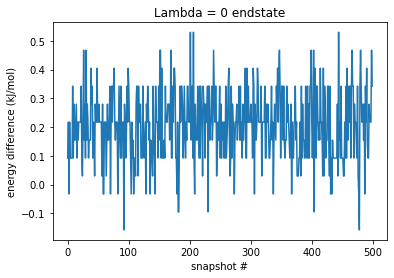

In [10]:
plt.plot(np.array(energies_og) - np.array(energies_hybrid))
plt.ylabel("energy difference (kJ/mol)")
plt.xlabel("snapshot #")
plt.title("Lambda = 0 endstate")
plt.show()

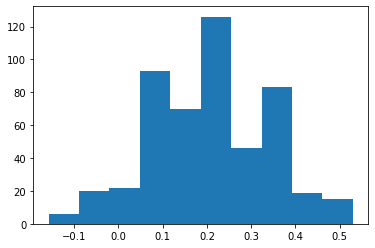

In [11]:
plt.hist(np.array(energies_og) - np.array(energies_hybrid))
plt.show()

In [12]:
np.mean(np.array(energies_og) - np.array(energies_hybrid))

0.204546044816263

In [13]:
np.std(np.array(energies_og) - np.array(energies_hybrid))

0.12270361235921169

In [15]:
with open("energies_rbd_ace2_hybrid.pickle", "wb") as f:
    pickle.dump(energies_hybrid, f)
with open("energies_rbd_ace2_og.pickle", "wb") as f:
    pickle.dump(energies_og, f)

## Test at lambda = 1

In [32]:
# htf = solvent_delivery.get_apo_htf()
with open("rbd_ace2_apo.pickle", "rb") as f:
    htf = pickle.load(f)
hybrid_system = htf.hybrid_system
hybrid_positions = htf.hybrid_positions
box_vectors = hybrid_system.getDefaultPeriodicBoxVectors()


In [33]:
htf.hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2ba99111e5a0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2ba99111ea80> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2ba99111eae0> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2ba99111e450> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2ba997801f30> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2ba99bb46ea0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2ba99bb469c0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ba99bb467b0> >]

In [34]:
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

# Create thermodynamic state
lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

# Set alchemical parameters
beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

print(compound_thermodynamic_state.lambda_rest_bonds)
print(compound_thermodynamic_state.lambda_alchemical_bonds_old)
print(compound_thermodynamic_state.lambda_alchemical_bonds_new)


1.0
0.0
1.0


In [35]:
integrator = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin, 
                                    collision_rate=1 / unit.picoseconds, 
                                    timestep=4 * unit.femtoseconds)
context = compound_thermodynamic_state.create_context(integrator)
context.setPositions(hybrid_positions)
context.setPeriodicBoxVectors(*box_vectors)
context.setVelocitiesToTemperature(300 * unit.kelvin)


In [36]:
# Minimize
openmm.LocalEnergyMinimizer.minimize(context)


In [37]:
# Run MD
# hybrid = list()
hybrid_states = list()
for _ in tqdm_notebook(range(int(125000/250))):
    integrator.step(250)
    state = context.getState(getPositions=True, enforcePeriodicBox=False)
    hybrid_states.append(state)
#     pos = context.getState(getPositions=True, enforcePeriodicBox=False).getPositions(asNumpy=True)
#     hybrid.append(pos)


/scratch/lsftmp/4055528.tmpdir/ipykernel_68104/2861022740.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(int(125000/250))):


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [38]:
with open("hybrid_states_rbd_ace2_lambda_1.pickle", "wb") as f:
    pickle.dump(hybrid, f)

In [39]:
with open("hybrid_states_rbd_ace2_lambda_1.pickle", "rb") as f:
    hybrid = pickle.load(f)

In [40]:
# Make context for og system
thermodynamic_state = ThermodynamicState(htf._topology_proposal.new_system, temperature=T_min)
integrator_og = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_og = thermodynamic_state.create_context(integrator_og)


# Zero the unique old/new valence in the hybrid system
bond_force_index = 1 
angle_force_index = 2 
torsion_force_index = 3 
custom_bond_force = hybrid_system.getForce(bond_force_index)
custom_angle_force = hybrid_system.getForce(angle_force_index)
custom_torsion_force = hybrid_system.getForce(torsion_force_index)
is_old = False
hybrid_to_bond_indices = htf._hybrid_to_new_bond_indices if is_old else htf._hybrid_to_old_bond_indices
hybrid_to_angle_indices = htf._hybrid_to_new_angle_indices if is_old else htf._hybrid_to_old_angle_indices
hybrid_to_torsion_indices = htf._hybrid_to_new_torsion_indices if is_old else htf._hybrid_to_old_torsion_indices
for hybrid_idx, idx in hybrid_to_bond_indices.items():
    p1, p2, hybrid_params = custom_bond_force.getBondParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-2] *= 0 # zero K_old
    hybrid_params[-1] *= 0 # zero K_new
    custom_bond_force.setBondParameters(hybrid_idx, p1, p2, hybrid_params)
for hybrid_idx, idx in hybrid_to_angle_indices.items():
    p1, p2, p3, hybrid_params = custom_angle_force.getAngleParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_angle_force.setAngleParameters(hybrid_idx, p1, p2, p3, hybrid_params)
for hybrid_idx, idx in hybrid_to_torsion_indices.items():
    p1, p2, p3, p4, hybrid_params = custom_torsion_force.getTorsionParameters(hybrid_idx)
    hybrid_params = list(hybrid_params)
    hybrid_params[-1] *= 0
    hybrid_params[-2] *= 0
    custom_torsion_force.setTorsionParameters(hybrid_idx, p1, p2, p3, p4, hybrid_params)

# Make context for hybrid system
T_min = 300 * unit.kelvin
T_max = 600 * unit.kelvin

lambda_protocol = RESTCapableLambdaProtocol()
lambda_zero_alchemical_state = RESTCapableRelativeAlchemicalState.from_system(hybrid_system)
thermostate = ThermodynamicState(hybrid_system, temperature=T_min)
compound_thermodynamic_state = CompoundThermodynamicState(thermostate,
                                                          composable_states=[lambda_zero_alchemical_state])

beta_0 = 1 / (kB * T_min)
beta_m = 1 / (kB * T_max)
global_lambda = 1
compound_thermodynamic_state.set_alchemical_parameters(global_lambda, beta_0, beta_m, lambda_protocol=lambda_protocol)

integrator_hybrid = openmmtools.integrators.LangevinIntegrator(temperature=300 * unit.kelvin,
                                          collision_rate=1 / unit.picoseconds,
                                          timestep= 4 * unit.femtoseconds)
context_hybrid = compound_thermodynamic_state.create_context(integrator_hybrid)

# Get energies for each conformation
energies_og = list()
energies_hybrid = list()
for state in tqdm_notebook(hybrid_states):
   
#     context_og.setPositions(htf.new_positions(pos))
    context_og.setPositions(htf.new_positions(state.getPositions(asNumpy=True)))
    context_og.setPeriodicBoxVectors(*state.getPeriodicBoxVectors())
    energy_og = context_og.getState(getEnergy=True).getPotentialEnergy()
    energies_og.append(energy_og.value_in_unit_system(unit.md_unit_system))
    
#     context_hybrid.setPositions(pos)
    context_hybrid.setState(state)
    energy_hybrid = context_hybrid.getState(getEnergy=True).getPotentialEnergy()
    energies_hybrid.append(energy_hybrid.value_in_unit_system(unit.md_unit_system))
    
    print(energy_og, energy_hybrid)

/scratch/lsftmp/4055528.tmpdir/ipykernel_68104/280257880.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pos in tqdm_notebook(hybrid):


  0%|          | 0/305 [00:00<?, ?it/s]

-221694.7456467396 kJ/mol -221694.73548905272 kJ/mol
-211725.31481193344 kJ/mol -211725.3058160422 kJ/mol
-204706.11665310804 kJ/mol -204706.10540276518 kJ/mol
-202700.83425680758 kJ/mol -202700.82383068604 kJ/mol
-196606.49615696643 kJ/mol -196606.48470694848 kJ/mol
-197616.13048806123 kJ/mol -197616.11771871796 kJ/mol
-186135.2830104679 kJ/mol -186135.2638664839 kJ/mol
-183800.95875915326 kJ/mol -183800.94419391 kJ/mol
-192300.89874743577 kJ/mol -192300.88779800758 kJ/mol
-152128.73923751386 kJ/mol -152128.70435730962 kJ/mol
-134841.51576933544 kJ/mol -134841.4914230942 kJ/mol
-183804.68814478524 kJ/mol -183804.67176592955 kJ/mol
-153579.64448392915 kJ/mol -153579.6056516871 kJ/mol
-150497.97859704762 kJ/mol -150497.9468932719 kJ/mol
-122801.57385003078 kJ/mol -122801.53211841389 kJ/mol
-188351.74930905714 kJ/mol -188351.73874250386 kJ/mol
-176533.65272227535 kJ/mol -176533.63088270923 kJ/mol
-155144.8990328433 kJ/mol -155144.8590595901 kJ/mol
-169596.1274662069 kJ/mol -169596.103466

-96758.57218651404 kJ/mol -96758.42130436243 kJ/mol
-149354.47325140226 kJ/mol -149354.4525934388 kJ/mol
-165949.67116358294 kJ/mol -165949.65119400318 kJ/mol
124540.51657795231 kJ/mol 124540.64017668 kJ/mol
-94261.93780458823 kJ/mol -94261.8284561319 kJ/mol
-121480.62321181793 kJ/mol -121480.59075900995 kJ/mol
-133593.6396700982 kJ/mol -133593.59997457272 kJ/mol
-182379.2098648831 kJ/mol -182379.20003256295 kJ/mol
-136513.0067682024 kJ/mol -136512.97720573182 kJ/mol
-74478.01769164228 kJ/mol -74477.98693931321 kJ/mol
-124173.13728974038 kJ/mol -124173.11326298033 kJ/mol
-70379.63567598048 kJ/mol -70379.56608178119 kJ/mol
-54402.55049429205 kJ/mol -54402.51080707967 kJ/mol
-138081.8467627276 kJ/mol -138081.81161888398 kJ/mol
-130867.62797095766 kJ/mol -130867.57028854005 kJ/mol
-126518.55901321722 kJ/mol -126518.51114191693 kJ/mol
-177956.45782075007 kJ/mol -177956.4426688265 kJ/mol
5166236.764589908 kJ/mol 5166236.844185673 kJ/mol
4004312.1145135676 kJ/mol 4004314.3019207167 kJ/mol
12

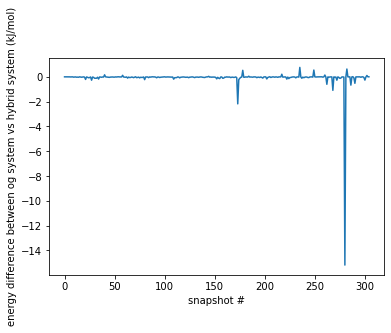

In [41]:
plt.plot(np.array(energies_og) - np.array(energies_hybrid))
plt.ylabel("energy difference between og system vs hybrid system (kJ/mol)")
plt.xlabel("snapshot #")
plt.show()

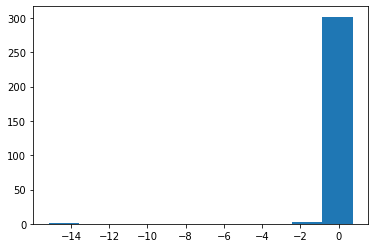

In [42]:
plt.hist(np.array(energies_og) - np.array(energies_hybrid))
plt.show()

In [23]:
diff = np.array(energies_og) - np.array(energies_hybrid)
diff[112]

-2.3724230397492647

In [29]:
diff[51]

-0.707159933866933

In [24]:
np.array(energies_og)[112], np.array(energies_hybrid)[112]

(8270022.855682447, 8270025.228105486)

In [30]:
np.array(energies_og)[51], np.array(energies_hybrid)[51]

(1376561.5401569547, 1376562.2473168885)

In [18]:
print(np.array(energies_og) - np.array(energies_hybrid))


[-0.01346908 -0.01067229 -0.01012315 -0.01221986 -0.00812304 -0.01459526
  0.01919606 -0.01974559 -0.03170726 -0.01377402 -0.01205406 -0.01659078
 -0.02664336 -0.01950886 -0.03504796 -0.01287016 -0.01482397 -0.01139997
 -0.05752246 -0.02414044 -0.02344317 -0.01241196 -0.13138499 -0.02416543
 -0.02663405 -0.03321857 -0.09940147 -0.02394162 -0.01827952 -0.01390322
 -0.01808958 -0.02705217 -0.01365297 -0.02384317 -0.02002375 -0.02534276
 -0.00549805 -0.0137345  -0.01805166 -0.10861181 -0.0662268  -0.05789296
 -0.05039494 -0.01586104 -0.03626614 -0.01795644 -0.01645997  0.10541786
 -0.09289358 -0.02308618 -0.17948118 -0.70715993 -0.01611057 -0.02530045
 -0.03263536 -0.05590057 -0.10972033 -0.21062642 -0.02024341  0.05777151
  0.20990809 -0.08555084 -0.02138034 -0.09679643 -0.0376456  -0.01579891
 -0.05797013 -0.01890206  0.01205472 -0.12387628 -0.02031007 -0.02964002
 -0.07108696 -0.02557722 -0.02469062 -0.05634577 -0.00856514 -0.19180412
 -0.03634591 -0.02043421 -0.06927997 -0.04028461 -0

In [27]:
np.std(np.array(energies_og) - np.array(energies_hybrid))

0.005789720133556094

In [28]:
with open("energies_rbd_ace2_hybrid_lambda_1.pickle", "wb") as f:
    pickle.dump(energies_hybrid, f)
with open("energies_rbd_ace2_og_lambda_1.pickle", "wb") as f:
    pickle.dump(energies_og, f)